In [1]:
import pandas as pd

#df1 = pd.read_excel("./data/anon_WMSPick20250101_03.xlsx") # Slechte data: timestamps kloppen niet
df2 = pd.read_excel("./data/anon_WMSPick20250104_06.xlsx")
df3 = pd.read_excel("./data/anon_WMSPick20250107_09.xlsx")
#df4 = pd.read_excel("./data/anon_WMSPick20250110_12.xlsx") # idem
df5 = pd.read_excel("./data/anon_WMSPick20250113_15.xlsx")
df6 = pd.read_excel("./data/anon_WMSPick20250116_19.xlsx")

dfs=[df2,df3,df5,df6]
df=pd.concat(dfs)
df = df[df['Out in'] != 'Outgoing']

df['Creation Dt'] = pd.to_datetime(df['Creation Dt'].astype(float), origin='1899-12-30', unit='D')
df['Last Change Dt'] = pd.to_datetime(df['Last Change Dt'].astype(float), origin='1899-12-30', unit='D')

#print(df.dtypes)
#print(df.head())

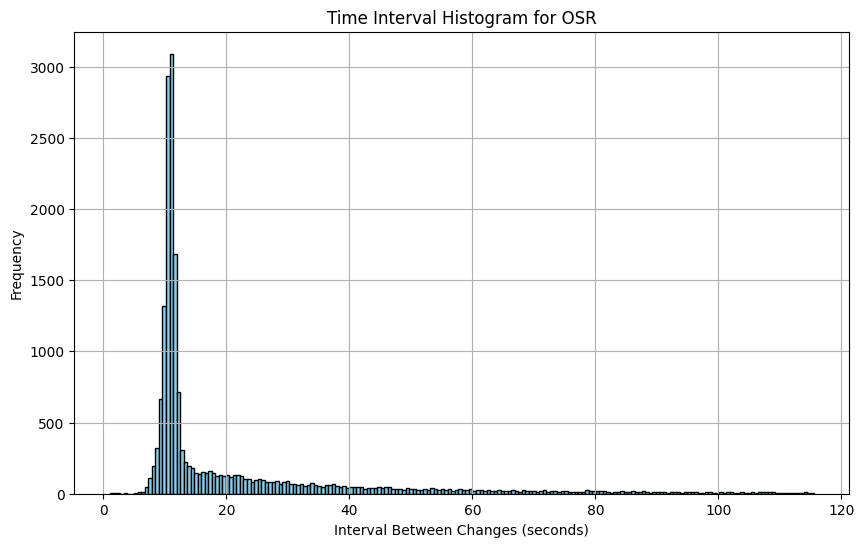

In [2]:
import matplotlib.pyplot as plt
loc = 'OSR'

# Step 1: Filter to just Picklist line number 1
loc_df = df[df['Location code'] == loc].sort_values(by='Last Change Dt')

# Step 2: Compute time differences
loc_df['Time Delta'] = loc_df['Last Change Dt'].diff()

# Step 3: Convert to seconds for plotting
loc_df['Delta Seconds'] = loc_df['Time Delta'].dt.total_seconds()

# Calculate lower and upper bounds using quantiles
upper_bound = loc_df['Delta Seconds'].quantile(0.99)

# Filter out outliers
filtered_intervals = loc_df['Delta Seconds'][
    (loc_df['Delta Seconds'] <= upper_bound) &
    (loc_df['Delta Seconds'] >= 1)
]

# Step 4: Drop NaN (first diff will be NaN) and plot
plt.figure(figsize=(10, 6))
plt.hist(filtered_intervals.dropna(), bins=200, color='skyblue', edgecolor='black')
plt.title('Time Interval Histogram for OSR')
plt.xlabel('Interval Between Changes (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Location code
OSR           86370
PTL-NEST14    10256
PTL-NEST12     9957
PTL-NEST26     9941
PTL-NEST21     9078
PTL-NEST23     9068
PTL-NEST13     8534
PTL-NEST15     7855
PTL-NEST16     7801
PTL-NEST25     7724
PTL-NEST24     7447
PTL-NEST11     7318
PTL-NEST22     7175
PACK           1712
BAK04C         1622
BAK04A         1585
BAK04B         1539
BAK04D         1308
BAK08B         1284
BAK08D         1116
Name: count, dtype: int64


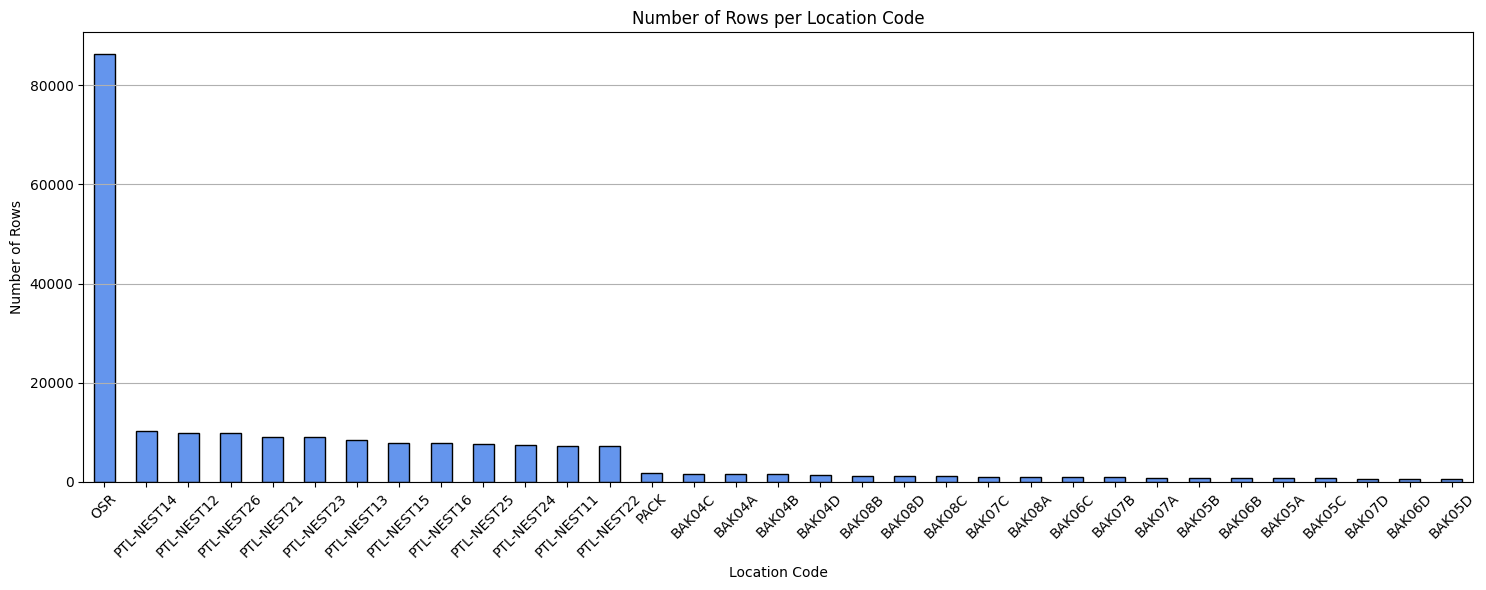

In [3]:
container_count = df['Location code'].value_counts()
container_count = container_count[container_count >= 500]  # Keep only counts ≥ 3

print(container_count.head(20))
# Step 2: Plot
plt.figure(figsize=(15, 6))
container_count.plot(kind='bar', color='cornflowerblue', edgecolor='black')

# Step 3: Beautify
plt.title('Number of Rows per Location Code')
plt.xlabel('Location Code')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

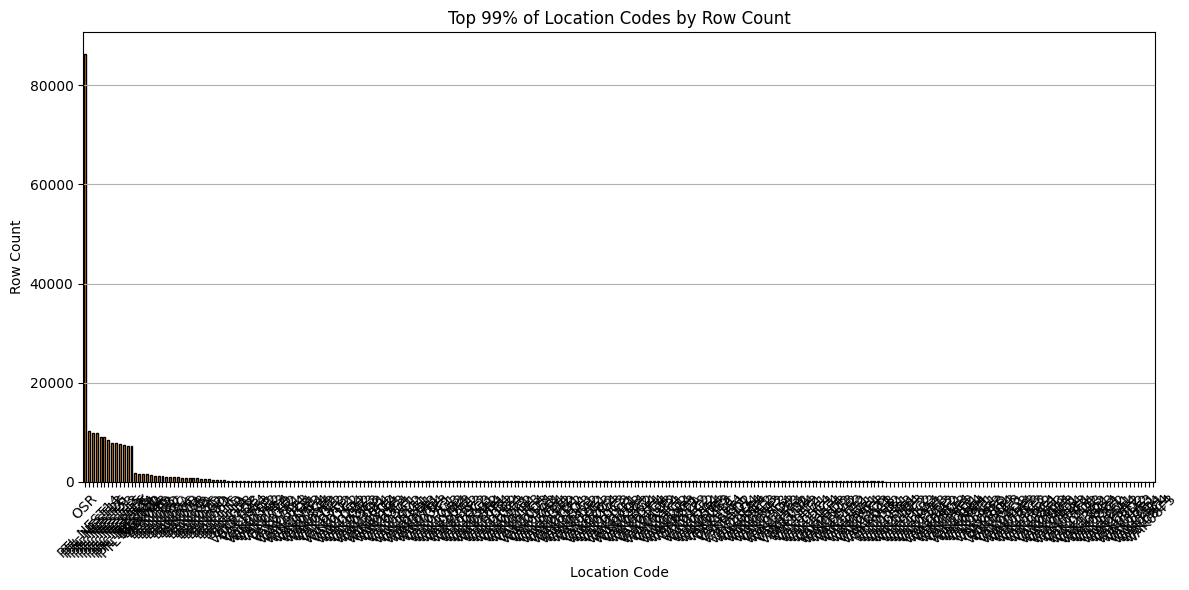

277 location codes make up 99% of the data.


In [4]:
# Step 1: Count rows per Location code
location_counts = df['Location code'].value_counts()

# Step 2: Calculate cumulative percentage
cumulative_percent = location_counts.cumsum() / location_counts.sum()

# Step 3: Filter to keep only the top 99%
top_99 = location_counts[cumulative_percent <= 0.99] #57% voor de top 13, OSR is de grootste (37%)

# Step 4: Plot
plt.figure(figsize=(12, 6))
top_99.plot(kind='bar', color='darkorange', edgecolor='black')

plt.title('Top 99% of Location Codes by Row Count')
plt.xlabel('Location Code')
plt.ylabel('Row Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
print(f"{len(top_99)} location codes make up 99% of the data.")


In [5]:
# Step 1: Compute time deltas per Location code
df_sorted = df.sort_values(by=['Location code', 'Last Change Dt'])
df_sorted['Time Delta'] = df_sorted.groupby('Location code')['Last Change Dt'].diff()

# Step 2: Convert to seconds
df_sorted['Delta Seconds'] = df_sorted['Time Delta'].dt.total_seconds()

# Step 3: Drop NaNs (first of each group) and group
mean_estimates = df_sorted.groupby('Location code')['Delta Seconds'].mean().dropna()

# Step 4: Convert mean intervals to Poisson λ
lambda_per_location = 1 / mean_estimates

print(lambda_per_location.head())


Location code
AEPACK02P    0.000001
AEPACK03P    0.000010
APACK01P     0.000002
APACK02P     0.000370
APACK03P     0.000007
Name: Delta Seconds, dtype: float64


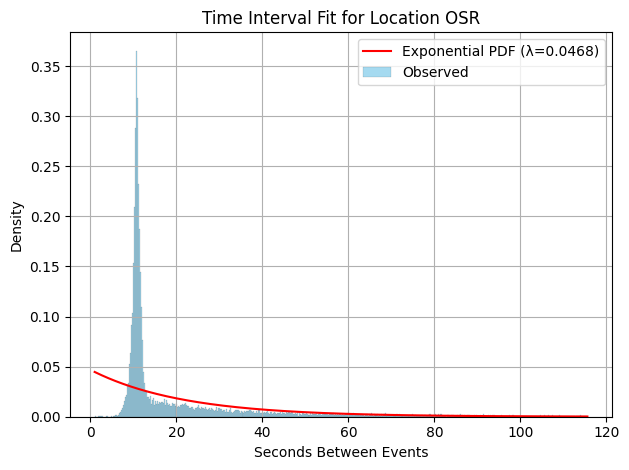

In [6]:
import seaborn as sns
import numpy as np

# Pick a location to visualize
lambda_hat = 1 / filtered_intervals.mean()

# Plot histogram with exponential fit
sns.histplot(filtered_intervals, bins=500, kde=False, stat='density', label='Observed', color='skyblue')

x = np.linspace(1, upper_bound, 500)
pdf = lambda_hat * np.exp(-lambda_hat * x)
plt.plot(x, pdf, label=f'Exponential PDF (λ={lambda_hat:.4f})', color='red')
plt.title(f"Time Interval Fit for Location {loc}")
plt.xlabel("Seconds Between Events")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


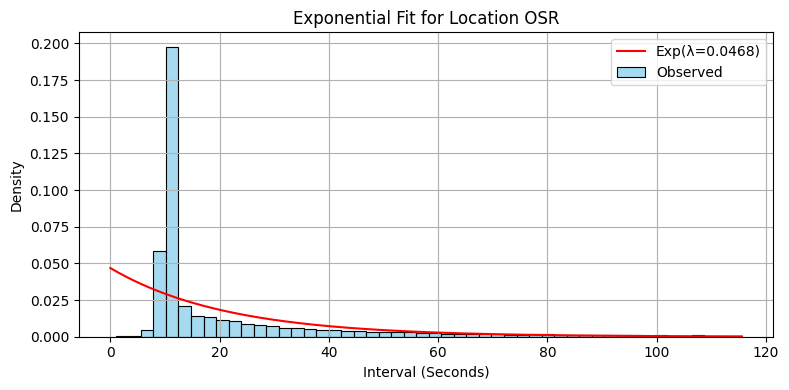

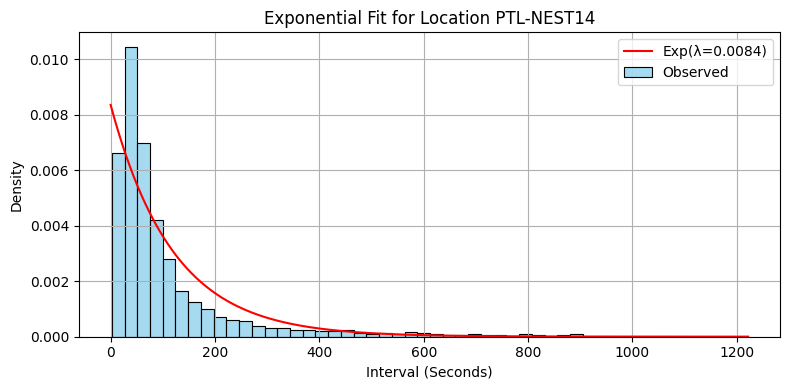

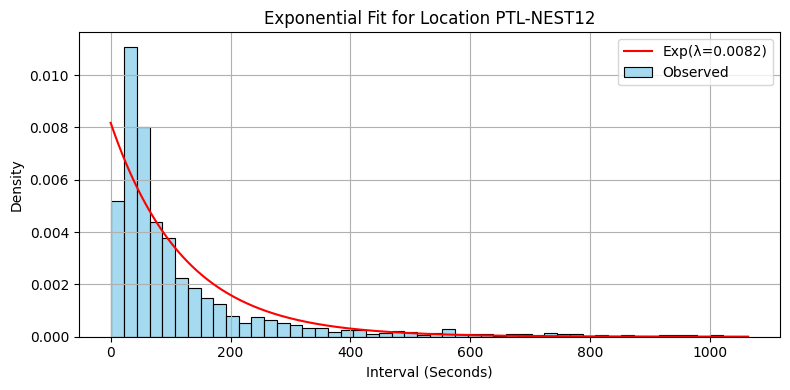

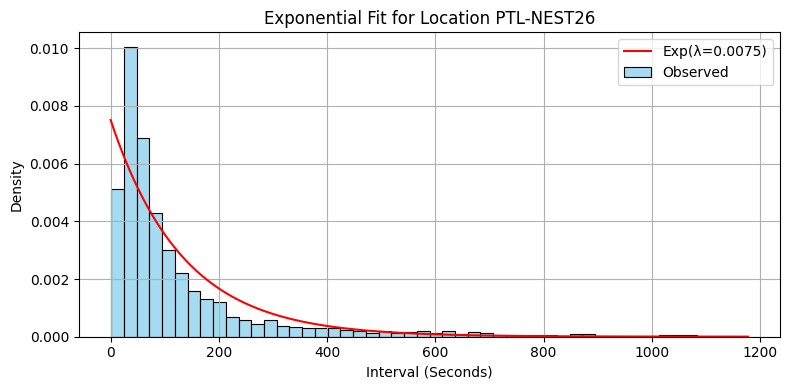

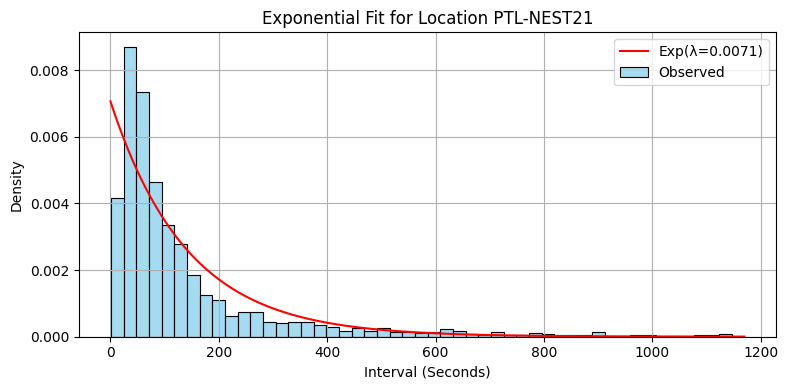

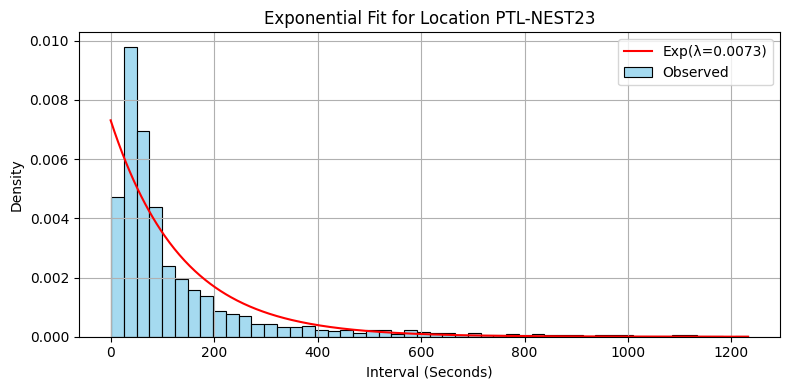

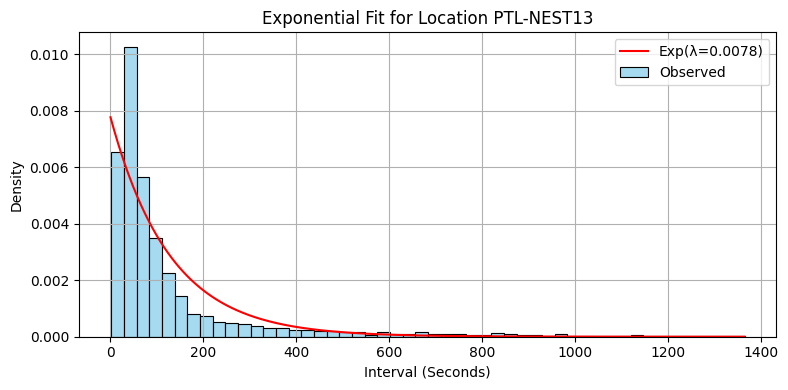

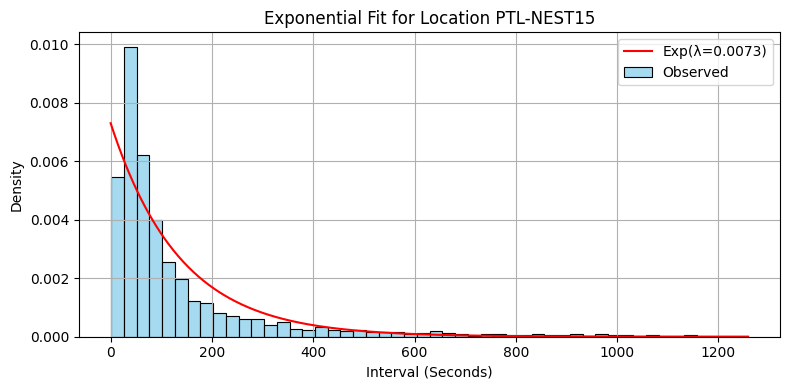

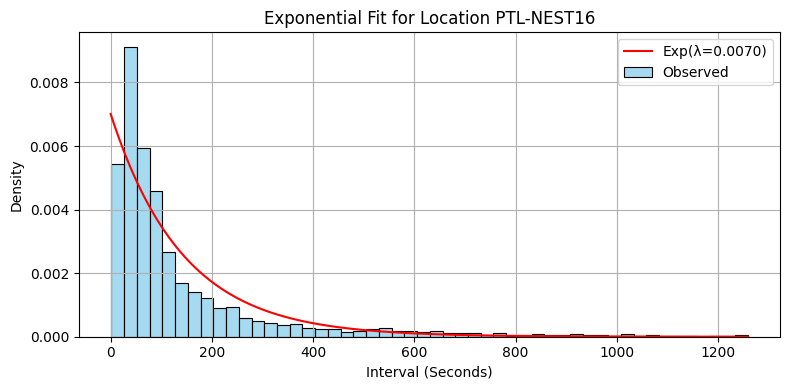

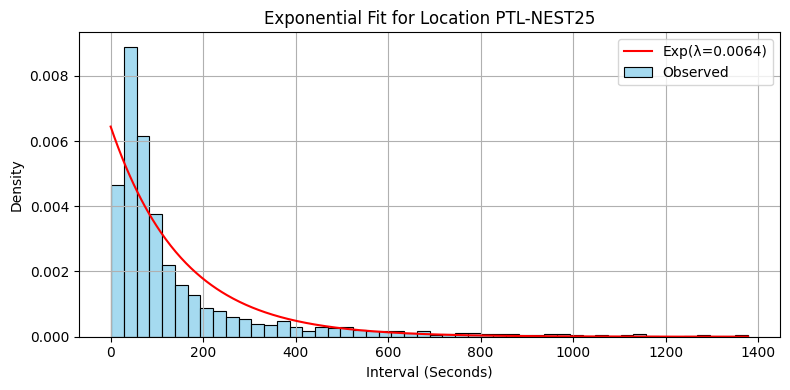

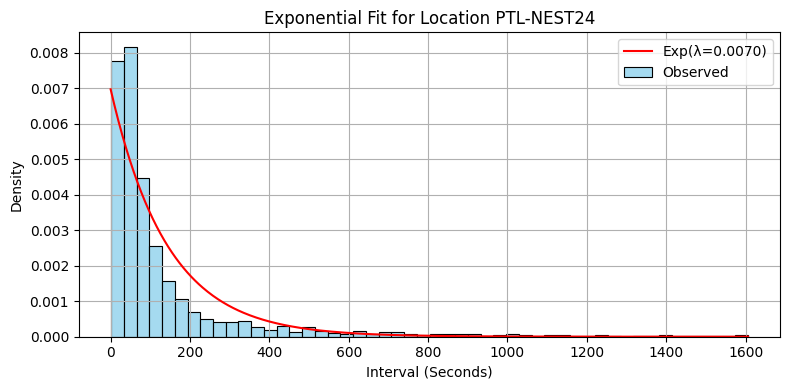

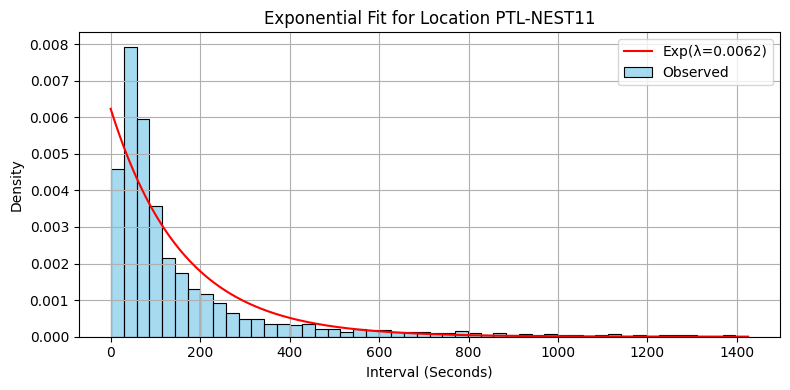

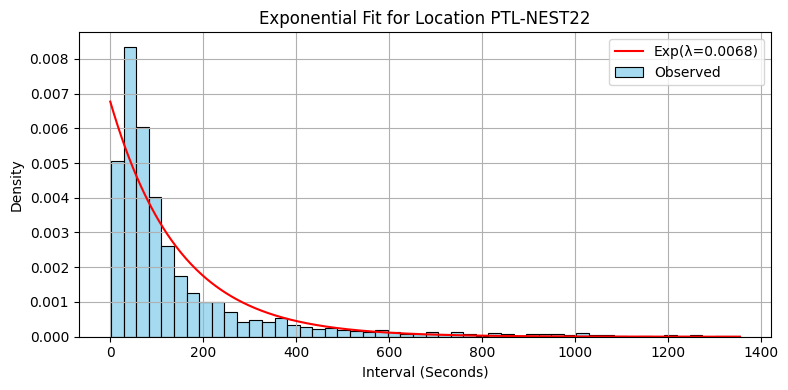

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Sort and compute intervals
df_sorted = df.sort_values(by=['Location code', 'Last Change Dt'])
df_sorted['Time Delta'] = df_sorted.groupby('Location code')['Last Change Dt'].diff()
df_sorted['Delta Seconds'] = df_sorted['Time Delta'].dt.total_seconds()

# Step 2: Get top 13 Location codes by row count
top_locations = df['Location code'].value_counts().head(13).index

# Step 3: Plot in loop
for loc in top_locations:
    df_loc = df_sorted[df_sorted['Location code'] == loc]
    upper_bound = df_loc['Delta Seconds'].quantile(0.99)

        # Filter out outliers
    intervals = df_loc['Delta Seconds'][
        (df_loc['Delta Seconds'] <= upper_bound) &
        (df_loc['Delta Seconds'] >= 1)
    ].dropna()


    if len(intervals) < 2:
        continue  # skip locations with too few intervals to plot

    lambda_hat = 1 / intervals.mean()

    # Plot
    plt.figure(figsize=(8, 4))
    sns.histplot(intervals, bins=50, stat='density', color='skyblue', label='Observed')

    x = np.linspace(0, intervals.max(), 500)
    pdf = lambda_hat * np.exp(-lambda_hat * x)
    plt.plot(x, pdf, color='red', label=f'Exp(λ={lambda_hat:.4f})')

    plt.title(f"Exponential Fit for Location {loc}")
    plt.xlabel("Interval (Seconds)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
orders = df[df['Outbound order number']==14569427]
order_size_count = df['Task number'].value_counts()
print(orders['Item code'].head())
#print(order_size_count)

duplicated_tasks = order_size_count[order_size_count > 1]
print(duplicated_tasks)


Series([], Name: Item code, dtype: int64)
Task number
14569427.0    30
14556582.0    26
14385390.0    25
14541545.0    19
14535858.0    19
              ..
14629013.0     2
14632729.0     2
14629560.0     2
14629027.0     2
14632162.0     2
Name: count, Length: 3961, dtype: int64


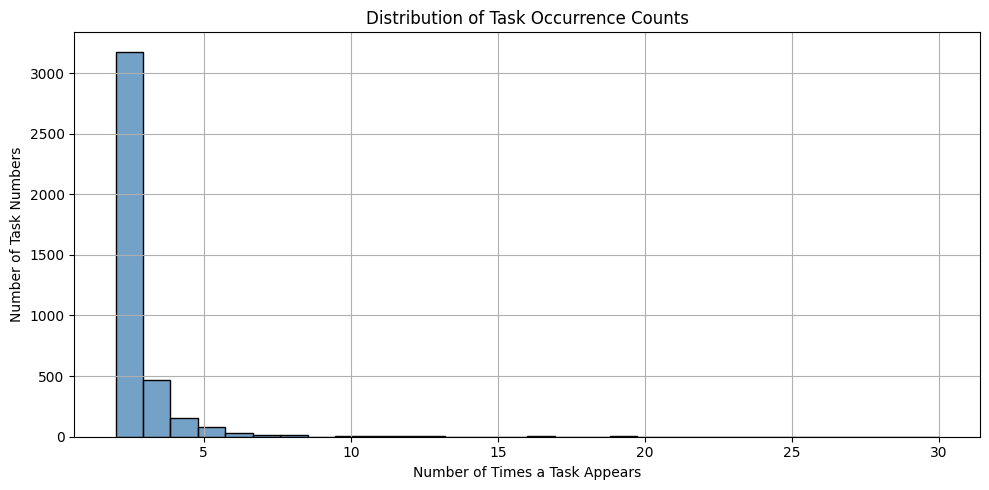

In [9]:
# Step 2: Plot the distribution of those counts
plt.figure(figsize=(10, 5))
sns.histplot(duplicated_tasks, bins=duplicated_tasks.max(), kde=False, color='steelblue')

plt.title('Distribution of Task Occurrence Counts')
plt.xlabel('Number of Times a Task Appears')
plt.ylabel('Number of Task Numbers')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
order_size_count = df['Outbound order number'].value_counts()
multi_item_tasks = order_size_count[order_size_count > 1]

# Get only items that appear in multi-item tasks
items_in_multi_item_tasks = df[df['Outbound order number'].isin(multi_item_tasks.keys())]['Item code'].unique()

# Now filter the original dataframe to only include those items
filtered_df = df[df['Item code'].isin(items_in_multi_item_tasks)]

# Build full task-item matrix with all tasks but filtered items
task_item_matrix = df[df['Item code'].isin(items_in_multi_item_tasks)] \
    .assign(present=1) \
    .pivot_table(index='Outbound order number', columns='Item code', values='present', fill_value=0) \
    .astype(int)

from scipy.sparse import csr_matrix

# Convert to sparse matrix
sparse_matrix = csr_matrix(task_item_matrix.values)

# Fast co-occurrence via sparse matrix multiplication
co_occurrence_sparse = sparse_matrix.T @ sparse_matrix

# Convert back to DataFrame with correct labels (optional)
co_occurrence_df = pd.DataFrame(
    co_occurrence_sparse.toarray(),
    index=task_item_matrix.columns,
    columns=task_item_matrix.columns
)

print(co_occurrence_df.head())

# Total tasks per item (including those where it's the only item!)
item_totals = df[df['Item code'].isin(items_in_multi_item_tasks)] \
    .groupby('Item code')['Outbound order number'].nunique()

print(item_totals)
# P(B|A) = # tasks with A and B / # tasks with A
conditional_probs = co_occurrence_df.div(item_totals, axis=1)


Item code  0      1      2      3      4      5      6      7      8      \
Item code                                                                  
0             28      0      0      0      5      0      0      0      0   
1              0      1      0      0      0      0      0      0      0   
2              0      0      7      0      0      0      4      0      5   
3              0      0      0      4      0      2      0      0      0   
4              5      0      0      0     26      0      0      0      0   

Item code  9      ...  29391  29392  29393  29394  29395  29396  29397  29398  \
Item code         ...                                                           
0              0  ...      0      0      0      0      0      0      0      0   
1              0  ...      0      0      0      0      0      0      0      0   
2              0  ...      0      0      0      0      0      0      0      0   
3              0  ...      0      0      0      0      0      

In [11]:
non_binary = conditional_probs[(conditional_probs != 0) & (conditional_probs != 1)]
#non_binary = non_binary.dropna(how='all')  # drop fully-empty rows

print(conditional_probs)

Item code     0      1      2      3         4         5      6      7      \
Item code                                                                    
0          1.000000    0.0    0.0    0.0  0.192308  0.000000    0.0    0.0   
1          0.000000    1.0    0.0    0.0  0.000000  0.000000    0.0    0.0   
2          0.000000    0.0    1.0    0.0  0.000000  0.000000    0.4    0.0   
3          0.000000    0.0    0.0    1.0  0.000000  0.222222    0.0    0.0   
4          0.178571    0.0    0.0    0.0  1.000000  0.000000    0.0    0.0   
...             ...    ...    ...    ...       ...       ...    ...    ...   
29396      0.000000    0.0    0.0    0.0  0.000000  0.000000    0.0    0.0   
29397      0.000000    0.0    0.0    0.0  0.000000  0.000000    0.0    0.0   
29398      0.000000    0.0    0.0    0.0  0.000000  0.000000    0.0    0.0   
29400      0.000000    0.0    0.0    0.0  0.000000  0.000000    0.0    0.0   
29401      0.000000    0.0    0.0    0.0  0.000000  0.000000    

In [19]:
co_occurrence_sparse.setdiag(0)  # remove diagonal
co_occurrence_sparse.eliminate_zeros()

# Step 4: Convert to coordinate (COO) format to access nonzero elements
from scipy.sparse import coo_matrix
coo = co_occurrence_sparse.tocoo()
item_names = task_item_matrix.columns
# Step 5: Filter and show pairs with > 30 co-occurrences
result = pd.DataFrame({
    'Item A': item_names[coo.row],
    'Item B': item_names[coo.col],
    'Order Count': coo.data
})

result = result[result['Order Count'] > 30].sort_values(by='Order Count', ascending=False).value_counts('Order Count')

print(result.head(100))


Order Count
31     1778
32     1686
33     1614
34     1586
35     1482
       ... 
131      66
121      66
126      64
137      64
133      64
Name: count, Length: 100, dtype: int64


In [13]:
# Group by Item code and count the number of unique Stock Product IDs
mapping_check = df.groupby('Requester user code')['Outbound order number'].nunique()

# Find Item codes that map to more than one Stock Product ID
inconsistent_items = mapping_check[mapping_check > 1]

# Show results
print(f"Total inconsistent items: {len(inconsistent_items)}")
print(inconsistent_items)


Total inconsistent items: 95
Requester user code
0       638
2       678
3       349
4      4328
5       183
       ... 
98      512
99     1332
100      30
101     285
102      34
Name: Outbound order number, Length: 95, dtype: int64
